In [1]:
# demo From Network
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
print(tf.test.is_gpu_available())
# import tensorflow_addons as tfad

--AA
AA--
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
import tensorflow as tf
import os
from glob import glob
# !pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math
import tensorflow.keras.preprocessing.image as prep


from copy import copy
import matplotlib.colors as colors
import matplotlib.image as mpimg

None
--AA
AA--


## Hyperparameters

In [3]:
# ## dataset paths
train_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\inputs/*'))
train_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\selected_masks\\raw/*'))
test_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val/*'))
test_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val_selected_masks\\raw/*'))

query_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\query_inputs/*'))
test_query_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val_query_inputs/*'))

# ## dataset paths in labe windows
# train_images = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\inputs/*'))
# train_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\selected_masks\\raw/*'))
# test_images = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\val/*'))
# test_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\val_selected_masks\\raw/*'))

# query_images = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\query_inputs/*'))
# test_query_images = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\val_query_inputs/*'))

# input info
# raw TIAS INPUT SIZE 1080X1920
raw_w = 1080
raw_h =  1920
# resize_factor =  4
# img_w =  raw_w // resize_factor 
# img_h =  raw_h // resize_factor
img_w =  128
img_h =  128 # Pretrained Keras model MobileNetV2 only accept the following input dimensions: [96, 128, 160, 192, 224] 

print("desired img w:", img_w)
print("desired img h:", img_h)


# parameters for model
BATCH_SIZE = 4
OUTPUT_CHANNELS = 3
print("len of query_images:", len(query_images))

print("len of test query_images:", len(test_query_images))

desired img w: 128
desired img h: 128
len of query_images: 219
len of test query_images: 3


## dataset and preprocess


tf.Tensor(b'E:\\dataset\\SublingualVein\\TIASRGB2020\\inputs\\1002dozono01 (1).bmp', shape=(), dtype=string)
tf.Tensor(b'E:\\dataset\\SublingualVein\\TIASRGB2020\\selected_masks\\raw\\1002dozono01 (1).png', shape=(), dtype=string)
inputs shape: (128, 128, 3)
masks shape: (128, 128, 3)
inputs shape: (128, 128, 3)
inputs shape: (128, 128, 3)
final_train_dataset.element_spec: ((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))
inputs shape: (128, 128, 3)
masks shape: (128, 128, 3)
input_image.shape (128, 128, 3)
seg_label.shape (128, 128, 3)

tr_input.shape: (4, 128, 128, 3)
tr_input.shape: (3, 128, 128, 3)


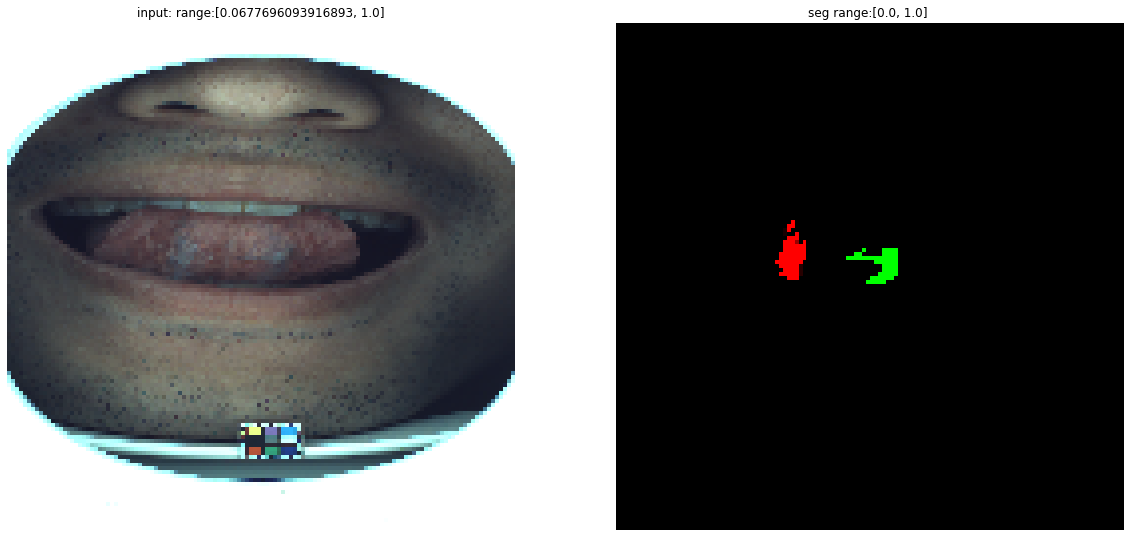

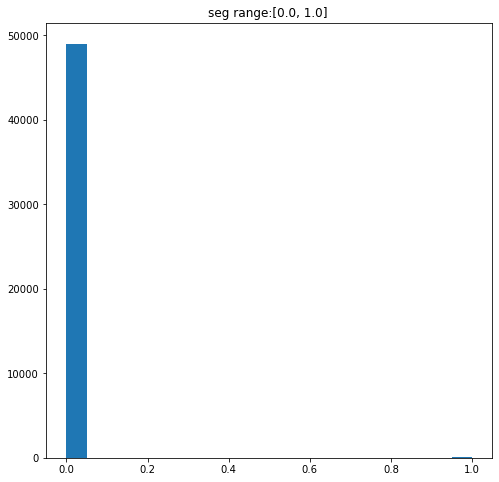

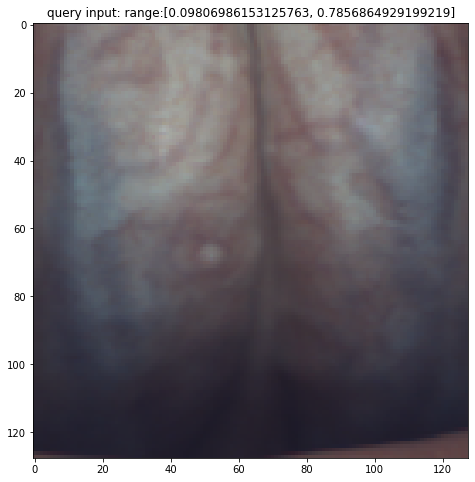

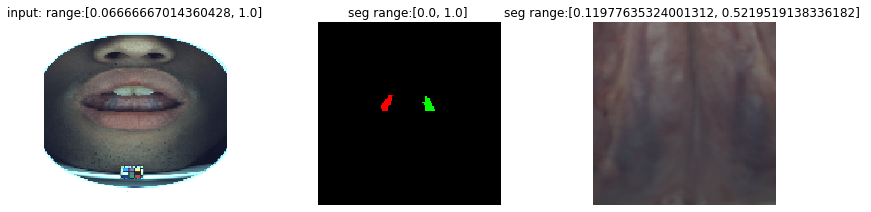

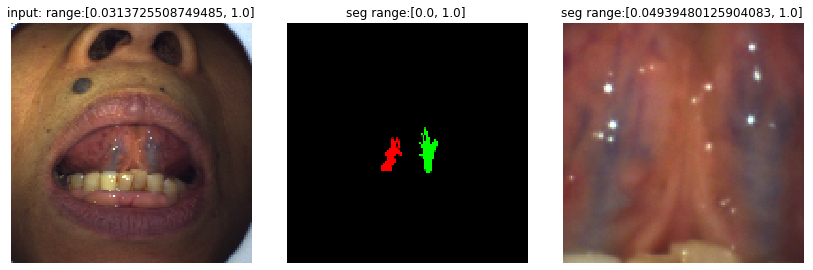

In [4]:
##  pre-processing funcs define
# # check the dataset
def plot_input_and_mask(img, seg_label):
#     palette = copy(plt.cm.gray)
#     palette.set_over('r', 1.0)
#     print("dicom_path:", dicom_path)
    print("input_image.shape", img.numpy().shape)
    print("seg_label.shape", seg_label.numpy().shape)

    fig, axes = plt.subplots(1,2, figsize=(20,20))
    
    print()
    axes[0].imshow(img)
    axes[0].set_title('input: range:[{}, {}]'.format((np.min(img)), np.max(img)))
    axes[0].axis('off')
    axes[1].imshow(seg_label)
    axes[1].set_title('seg range:[{}, {}] '.format(np.min(seg_label), np.max(seg_label)))
    axes[1].axis('off')
#     axes[2].hist(seg_label.numpy().reshape((-1)), bins= 20)
#     axes[2].set_title('seg range:[{}, {}] '.format(np.min(seg_label), np.max(seg_label)))
#     axes[2].axis('off')

def decode_img(img_bytes, img_type="bmp"):
    # conver compuresed string to a 3D unit8 tensor
    if img_type == "bmp":
        img = tf.io.decode_bmp(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # this will nomrlize within (0 , max)
    else:
        img =tf.io.decode_png(img_bytes, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.

    # resize the image to the desired size.
    return tf.image.resize(img, [img_h, img_w])  # A 1-D int32 Tensor of 2 elements: new_height, new_width. The new size for the images.
    
def label_norm(label):
    label /=128
    return label
    
    
def load_image(image_path, img_type = "bmp"):
    img_bytes = tf.io.read_file(image_path)
    decoded_img = decode_img(img_bytes, img_type)
    return decoded_img

@tf.function
def train_process_func(image_path, mask_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape)
    # load mask 
    masks = load_image(mask_path, "png")
    masks =  label_norm(masks)
    print("masks shape:", masks.shape)
    
#     preprocessing
    if tf.random.uniform(()) > 0.5:
        inputs = tf.image.flip_left_right(inputs)
        masks = tf.image.flip_left_right(masks)
        # need to swap green and red channel
        r, g, b =  tf.split(masks, 3, axis=-1)

        masks =  tf.concat([g, r, b], axis=-1)
        
    return inputs, masks

@tf.function
def test_process_func(image_path, mask_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape)
    # load mask 
    masks = load_image(mask_path, "png")
    masks =  label_norm(masks)
    print("masks shape:", masks.shape)
    return inputs, masks

@tf.function
def train_query_process_func(image_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape) 
    return inputs


@tf.function
def test_query_process_func(image_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape) 
    return inputs

# genrate dataset from dataset paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))       
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))  

query_dataset = tf.data.Dataset.from_tensor_slices(query_images)  
test_query_dataset = tf.data.Dataset.from_tensor_slices(test_query_images)  
# check the train_dataset from the paths
print("")
for data in train_dataset.take(1):
    print(data[0])
    print(data[1])

train_dataset = train_dataset.shuffle(300)
query_dataset = query_dataset.shuffle(300)

# train_dataset = train_dataset.map(map_func=train_process_func,
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).repeat()    #
train_dataset = train_dataset.map(map_func=train_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)  # if use for lop directly on the dataset no repeat()
query_dataset =  query_dataset.map(map_func=train_query_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE) 
test_query_dataset =  test_query_dataset.map(map_func=test_query_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE) 

final_train_dataset =  tf.data.Dataset.zip((train_dataset, query_dataset))

print("final_train_dataset.element_spec:", final_train_dataset.element_spec)


test_dataset = test_dataset.map(map_func=test_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)   
final_test_dataset =  tf.data.Dataset.zip((test_dataset, test_query_dataset))
# check the train image
for inputs, masks in train_dataset.take(1):
    plot_input_and_mask(inputs[0], masks[0])
    fig2, axes2 = plt.subplots(1,1, figsize=(8,8))
    axes2.hist( masks[0].numpy().reshape((-1)), bins= 20)
    axes2.set_title('seg range:[{}, {}] '.format(np.min( masks[0]), np.max( masks[0])))
    
for query_img in query_dataset.take(1):
    fig3, axes3 = plt.subplots(1,1, figsize=(8,8))
    axes3.imshow( query_img[0])
    axes3.set_title('query input: range:[{}, {}]'.format((np.min(query_img)), np.max(query_img)))
    
for final_element in final_train_dataset.take(1):
    tr_input =  final_element[0][0]
    tr_label =  final_element[0][1]
    tr_query =  final_element[1]
    fig4, axes4 = plt.subplots(1,3, figsize=(12,12))
    print("tr_input.shape:", tr_input.shape)
    axes4[0].imshow(tr_input[0])
    axes4[0].set_title('input: range:[{}, {}]'.format((np.min(tr_input)), np.max(tr_input)))
    axes4[0].axis('off')
    axes4[1].imshow(tr_label[0])
    axes4[1].set_title('seg range:[{}, {}] '.format(np.min(tr_label), np.max(tr_label)))
    axes4[1].axis('off')
    axes4[2].imshow(tr_query[0])
    axes4[2].set_title('seg range:[{}, {}] '.format(np.min(tr_query), np.max(tr_query)))
    axes4[2].axis('off')
    plt.tight_layout()
    
for final_element in final_test_dataset.take(1):
    tr_input =  final_element[0][0]
    tr_label =  final_element[0][1]
    tr_query =  final_element[1]
    fig4, axes4 = plt.subplots(1,3, figsize=(12,12))
    print("tr_input.shape:", tr_input.shape)
    axes4[0].imshow(tr_input[0])
    axes4[0].set_title('input: range:[{}, {}]'.format((np.min(tr_input)), np.max(tr_input)))
    axes4[0].axis('off')
    axes4[1].imshow(tr_label[0])
    axes4[1].set_title('seg range:[{}, {}] '.format(np.min(tr_label), np.max(tr_label)))
    axes4[1].axis('off')
    axes4[2].imshow(tr_query[0])
    axes4[2].set_title('seg range:[{}, {}] '.format(np.min(tr_query), np.max(tr_query)))
    axes4[2].axis('off')
    plt.tight_layout()

## model design

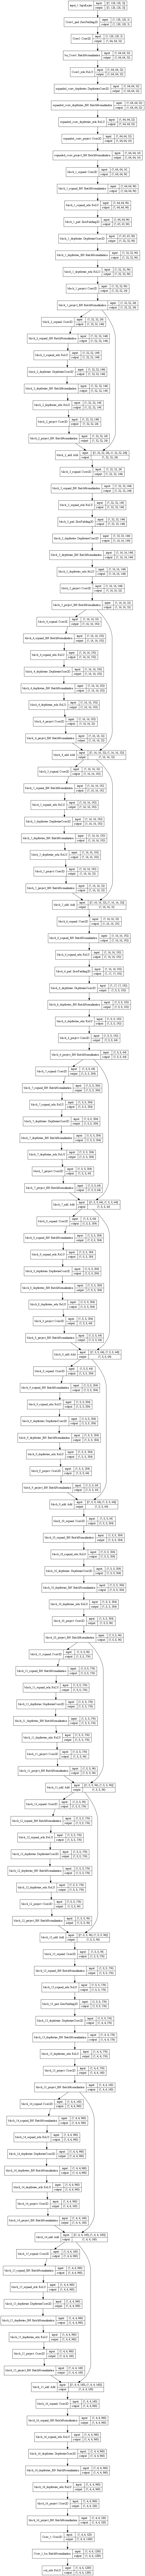

In [5]:
# BASE MODEL

base_model = tf.keras.applications.MobileNetV2(input_shape=[img_h, img_w, 3], include_top=False, weights=None)
tf.keras.utils.plot_model(base_model, to_file="base_MobileNetV2.png", show_shapes=True, dpi=64)

layers: [<tf.Tensor 'block_1_expand_relu/Identity:0' shape=(None, 64, 64, 96) dtype=float32>, <tf.Tensor 'block_3_expand_relu/Identity:0' shape=(None, 32, 32, 144) dtype=float32>, <tf.Tensor 'block_6_expand_relu/Identity:0' shape=(None, 16, 16, 192) dtype=float32>, <tf.Tensor 'block_13_expand_relu/Identity:0' shape=(None, 8, 8, 576) dtype=float32>, <tf.Tensor 'block_16_project/Identity:0' shape=(None, 4, 4, 320) dtype=float32>]


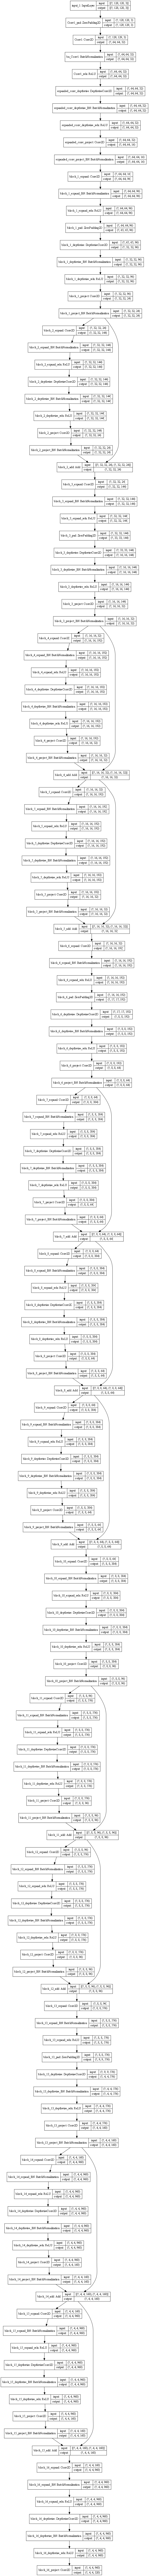

In [6]:
# Use the activations of these layers. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
print('layers:', layers)

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True
tf.keras.utils.plot_model(down_stack, to_file="down_stack.png", show_shapes=True, dpi=64)

skips_query [<tf.Tensor 'model/Identity:0' shape=(None, 64, 64, 96) dtype=float32>, <tf.Tensor 'model/Identity_1:0' shape=(None, 32, 32, 144) dtype=float32>, <tf.Tensor 'model/Identity_2:0' shape=(None, 16, 16, 192) dtype=float32>, <tf.Tensor 'model/Identity_3:0' shape=(None, 8, 8, 576) dtype=float32>, <tf.Tensor 'model/Identity_4:0' shape=(None, 4, 4, 320) dtype=float32>]
skips_input [<tf.Tensor 'model_1/Identity:0' shape=(None, 64, 64, 96) dtype=float32>, <tf.Tensor 'model_1/Identity_1:0' shape=(None, 32, 32, 144) dtype=float32>, <tf.Tensor 'model_1/Identity_2:0' shape=(None, 16, 16, 192) dtype=float32>, <tf.Tensor 'model_1/Identity_3:0' shape=(None, 8, 8, 576) dtype=float32>, <tf.Tensor 'model_1/Identity_4:0' shape=(None, 4, 4, 320) dtype=float32>]
concat_skip.shape: (None, 64, 64, 192)
concat_skip_1x1.shape (None, 64, 64, 96)
concat_skip.shape: (None, 32, 32, 288)
concat_skip_1x1.shape (None, 32, 32, 144)
concat_skip.shape: (None, 16, 16, 384)
concat_skip_1x1.shape (None, 16, 16, 1

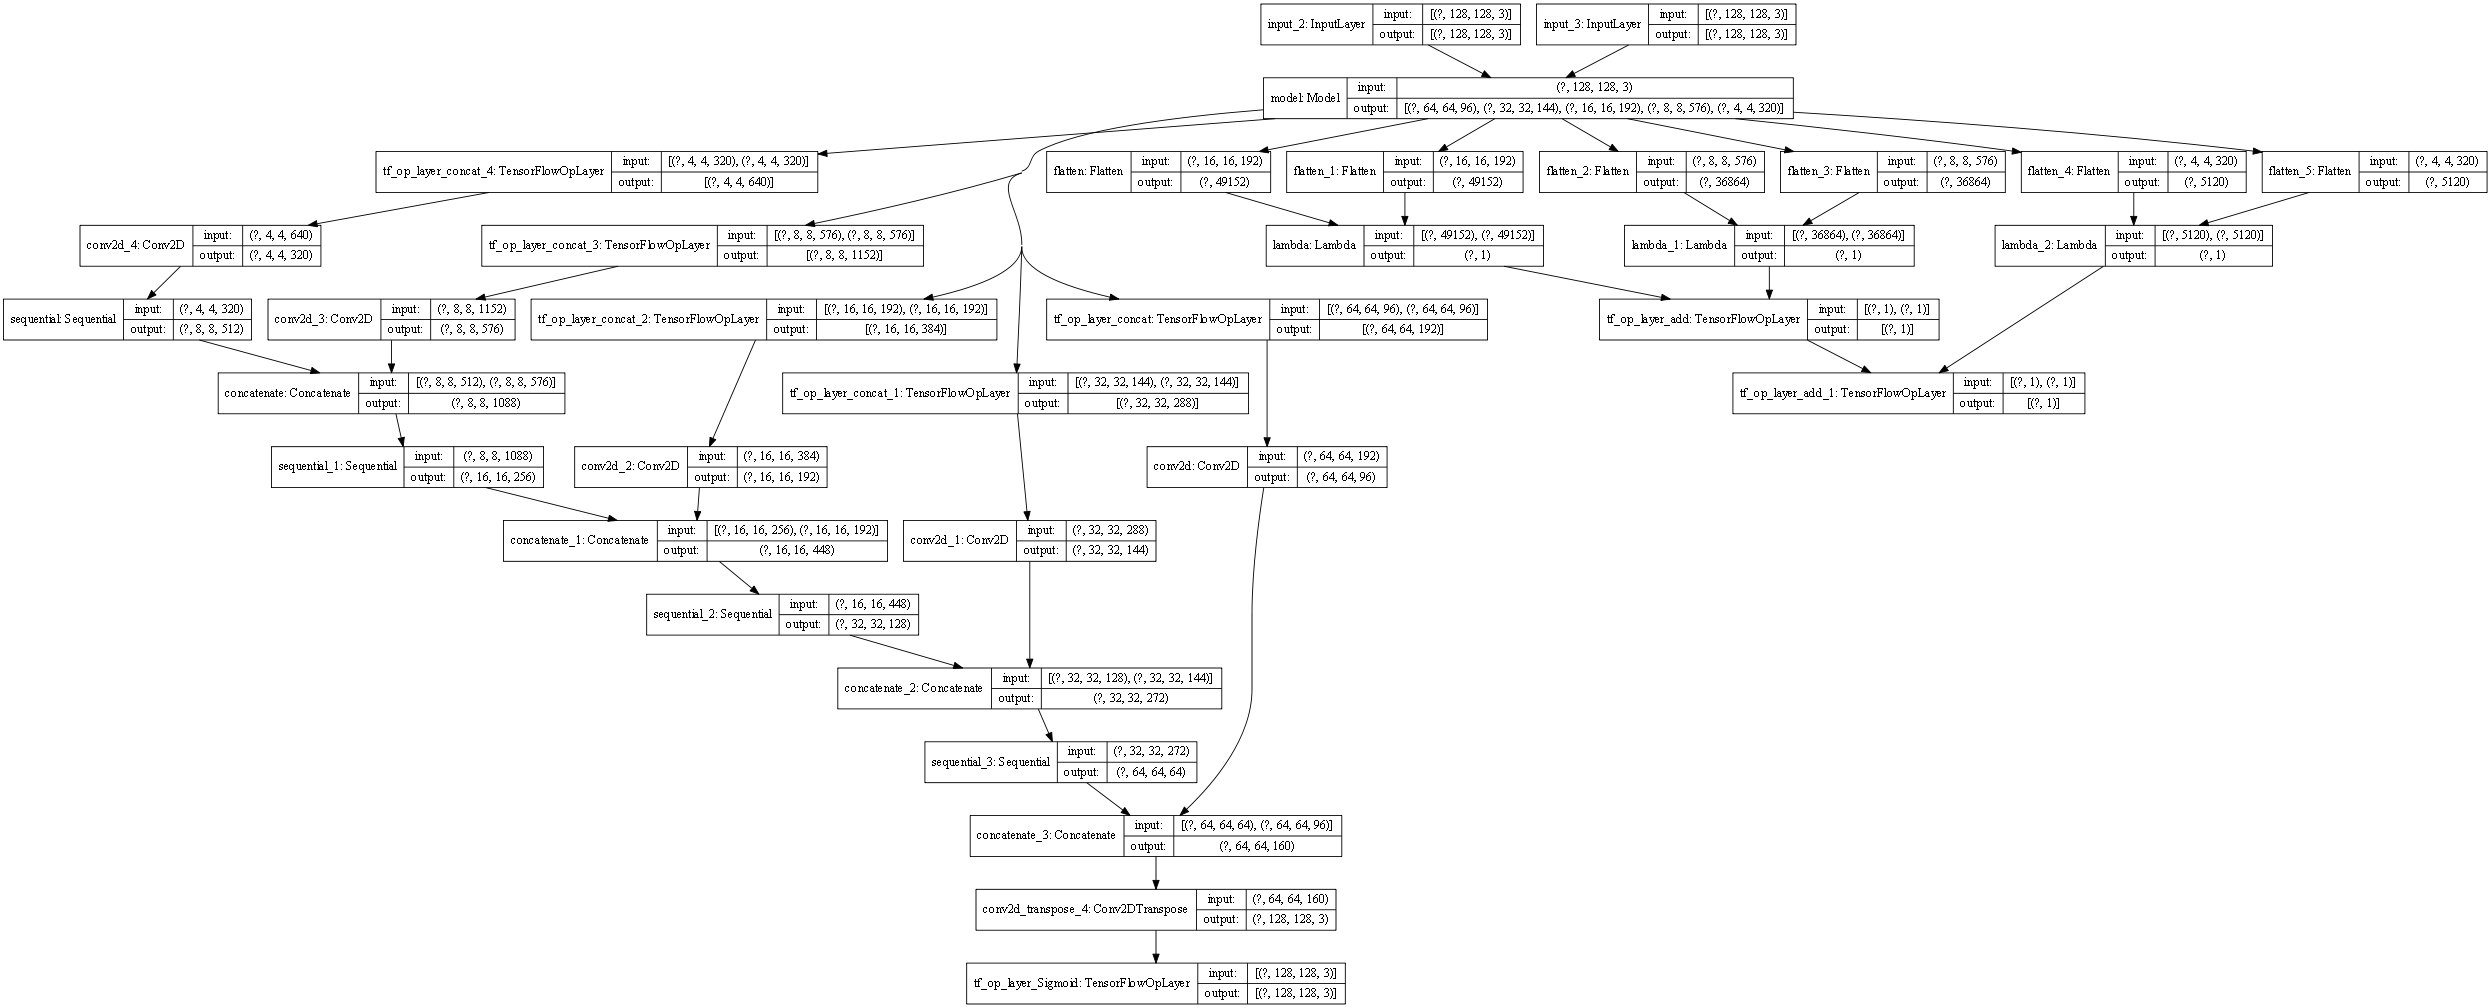

In [7]:
# The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.
from tensorflow.keras.layers import Lambda

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


def gram_matrix(features, normalize=True):
    """ Compute the Gram matrix from features. Inputs: - features: Tensor of shape (1, H, W, C) giving features for a single image. - normalize: optional, whether to normalize the Gram matrix If True, divide the Gram matrix by the number of neurons (H * W * C) Returns: - gram: Tensor of shape (C, C) giving the (optionally normalized) Gram matrices for the input image. """
    shape = tf.shape(features)
    features_reshaped = tf.reshape(features, (shape[1]*shape[2], shape[3]))
    gram = tf.matmul(tf.transpose(features_reshaped), features_reshaped)
    if normalize:
        gram /= tf.cast((shape[3] * shape[1] * shape[2]), tf.float32)
    return gram

def style_loss(feats, q_extracted_style_layers, i_extracted_style_layers):
    """ Computes the style loss at a set of layers. Inputs: - feats: list of the features at every layer of the current image, as produced by the extract_features function. - style_layers: List of layer indices into feats giving the layers to include in the style loss. - style_targets: List of the same length as style_layers, where style_targets[i] is a Tensor giving the Gram matrix the source style image computed at layer style_layers[i]. - style_weights: List of the same length as style_layers, where style_weights[i] is a scalar giving the weight for the style loss at layer style_layers[i]. Returns: - style_loss: A Tensor contataining the scalar style loss. """
    total_loss = 0.0
    for i in range(len(q_extracted_style_layers)):
        q_layer_features = q_extracted_style_layers[i]
        i_layer_feautres =  i_extracted_style_layers[i]
        A = gram_matrix(feats[style_layers[i]])
        total_loss += style_weights[i]*tf.reduce_sum((G - A)**2)

    return total_loss

def euclidean_distance(vects):
    x, y = vects
    sum_square =tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(K.maximum(sum_square, tf.keras.backend.epsilon()))

def unet_model(output_channels):
    # Create the feature extraction model, input both query input and train _input as pair 
    query_input = tf.keras.layers.Input(shape=[img_h, img_w,3])
    train_input = tf.keras.layers.Input(shape=[img_h, img_w,3])
      
#     inputs = tf.keras.layers.Input(shape=[img_h, img_w, 3])
    x_q = query_input
    x_i = train_input
    # Downsampling through the model, siamese Network share the same weights
    skips_query = down_stack(x_q)
    print("skips_query", skips_query)
    skips_input = down_stack(x_i)
    print("skips_input", skips_input)
    
    
#     # style loss
#     style_loss = 
    query_output_features = []
    input_output_features = []
    
    skips_each_connect = []
    for i in range(len(skips_query)):
        # concat:
        concat_skip= tf.concat([skips_query[i], skips_input[i]], axis = -1)
        print("concat_skip.shape:", concat_skip.shape)
        # 1x1 convolutions summary 
        concat_skip_1x1 =  tf.keras.layers.Conv2D(
              filters=concat_skip.shape[-1]//2, kernel_size=1, strides=(1, 1), activation='relu')(concat_skip)
        print("concat_skip_1x1.shape", concat_skip_1x1.shape)
        
        skips_each_connect.append(concat_skip_1x1)
        
        if i>1:
            query_output_features.append(skips_query[i])
            input_output_features.append(skips_query[i])
    #
    print("skips_each_connect summary:", skips_each_connect)
    
    
    # calculate euclidean_distance for sepcified output skp features
    for i in range(len(query_output_features)):
        query_f_vect =  tf.keras.layers.Flatten()(query_output_features[i])
        print("query_f_vect.shape:", query_f_vect.shape)
        input_f_vect =  tf.keras.layers.Flatten()(input_output_features[i])
        ed_loss_layer = Lambda(euclidean_distance)([query_f_vect,input_f_vect])
        
        if i ==0:
            ed_loss =  ed_loss_layer
        else: 
            ed_loss = ed_loss + ed_loss_layer
        
    
    x = skips_each_connect[-1]
    skips_each_connect = reversed(skips_each_connect[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips_each_connect):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    
    x =  tf.sigmoid(x)

    return tf.keras.Model(inputs=[query_input, train_input], outputs=[x, ed_loss])
One_shot_MobileNetV2UNet = unet_model(OUTPUT_CHANNELS)
tf.keras.utils.plot_model(One_shot_MobileNetV2UNet, to_file="One_shot_MobileNetV2UNet.png", show_shapes=True, dpi=64)

In [8]:
# for the global content and style loss


## prepare training

In [9]:
# project_name
project_name = "DemoSegTF2SigmoidDecayLrNorm1SigmoidFlipOneShotV1_FT_True_LogEdLoss_NoWeights/"
if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
train_save_figure_path = project_name + "AE_saves/train"
test_save_figure_path = project_name + "AE_saves/test"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# -------------------------------------------------------------------------->

## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)
train_full_AE_saves =  os.path.join(cwd, train_save_figure_path)
test_full_AE_saves =  os.path.join(cwd, test_save_figure_path)
print("train_full_AE_saves:", train_full_AE_saves)
print("test_full_AE_saves:", test_full_AE_saves)


if not os.path.exists(train_full_AE_saves):
    os.makedirs(train_full_AE_saves)

if not os.path.exists(test_full_AE_saves):
    os.makedirs(test_full_AE_saves)
    
    
train_predictions_save_path =os.path.join(train_full_AE_saves, "Predictions")
# train_clsDistr_save_path =os.path.join(train_full_AE_saves, "ClassDistruibution")

test_predictions_save_path =os.path.join(test_full_AE_saves, "Predictions")

# test_confusion_matrix =  os.path.join(test_full_AE_saves, "Confusion_Matrix")
# test_cm_diags =  os.path.join(test_full_AE_saves, "Confusion_Matrix_diagnoise_with_Epoch")

# test_batch_losses =  os.path.join(test_full_AE_saves, "Test_batch_losses")

test_EpochValidation_save_path =os.path.join(test_full_AE_saves, "EpochValidation")
# test_EpochValidation_save_path_pred =os.path.join(test_EpochValidation_save_path, "PredictionsOnly")
if not os.path.exists(train_predictions_save_path):
    os.makedirs(train_predictions_save_path)
# if not os.path.exists(train_clsDistr_save_path):
#     os.makedirs(train_clsDistr_save_path)
    
if not os.path.exists(test_predictions_save_path):
    os.makedirs(test_predictions_save_path)
if not os.path.exists(test_EpochValidation_save_path):
    os.makedirs(test_EpochValidation_save_path)
# if not os.path.exists(test_EpochValidation_save_path_pred):
#     os.makedirs(test_EpochValidation_save_path_pred)   
# if not os.path.exists(test_confusion_matrix):
#     os.makedirs(test_confusion_matrix)       
# if not os.path.exists(test_cm_diags):
#     os.makedirs(test_cm_diags) 
# if not os.path.exists(test_batch_losses):
#     os.makedirs(test_batch_losses)   
    
#     plt.show()

# 
import datetime

# for tensorboard writers
datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

%reload_ext tensorboard
%tensorboard --logdir {log_dir}

current working directory: E:\Projects\TF2\SublingualVein\2020May
train_full_AE_saves: E:\Projects\TF2\SublingualVein\2020May\DemoSegTF2SigmoidDecayLrNorm1SigmoidFlipOneShotV1_FT_True_LogEdLoss_NoWeights/AE_saves/train
test_full_AE_saves: E:\Projects\TF2\SublingualVein\2020May\DemoSegTF2SigmoidDecayLrNorm1SigmoidFlipOneShotV1_FT_True_LogEdLoss_NoWeights/AE_saves/test


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 3372.

In [10]:
# design new loss for the new model as new_train_step, new_test_step
# new_optimizer =  tf.keras.optimizers.Adam(1e-4)
# from tf.keras.utils import to_categorical
# BCE =  tf.keras.losses.BinaryCrossentropy() 
# Huber =  tf.keras.losses.Huber(delta=0.1)
# SCC = tf.keras.losses.SparseCategoricalCrossentropy()

@tf.function
def dice_coef(y_true, y_pred, smooth=1, input_type="RGB"):
    if input_type == "RGB":
        y_true =  tf.image.rgb_to_grayscale(y_true)
        y_pred = tf.image.rgb_to_grayscale(y_pred)
        
    else: pass
    y_true =  tf.cast(tf.math.greater(y_true, 0), tf.float32)
    y_pred =  tf.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    print("y_true.shape", y_true.shape)
    print("y_pred.shape",y_pred.shape)
    
    intersection = tf.math.reduce_sum(y_true * y_pred)
    union = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred)
    dice = tf.reduce_mean((2. * intersection + smooth)/(union + smooth))
    return dice

@tf.function
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

@tf.function
def Smooth_l1_loss(labels,predictions):
    diff=tf.abs(labels-predictions)
    less_than_one=tf.cast(tf.less(diff,1.0),tf.float32)   #Bool to float32
    smooth_l1_loss=(less_than_one*0.5*diff**2)+(1.0-less_than_one)*(diff-0.5)#同上图公式
    return tf.reduce_mean(smooth_l1_loss)

@tf.function
def dice_loss(y_true, y_pred):
    dice_loss =  1- dice_coef(y_true, y_pred)
    return dice_loss


@tf.function()
# define losses
def new_compute_loss(pred, seg_label, ed_pred):
    
#     #seg  cross_entropy,  use reduce mean not sum, otherwise loss will be very big
#     cls_BCE_loss1 = BCE(y_true=cls_tars[0], y_pred=preds[0]) 
#     cls_BCE_loss2 = BCE(y_true=cls_tars[1], y_pred=preds[1]) 
    ed_pred_loss = -tf.math.log(ed_pred)
    L1_smooth_loss = Smooth_l1_loss(seg_label, pred) 
    Dice_loss = dice_loss(seg_label, pred)
    total_loss = L1_smooth_loss + Dice_loss + ed_pred_loss

    return total_loss, ed_pred_loss
    

# @tf.function()
def new_train_step(model, optimizer, inputs, seg_target, training):
    # change cls labe 0 or 1 into  [1, 0] [0, 1]
#     print(cls_target)
#     cls_target = mask_to_categorical(cls_target)
#     print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        # outputs=[seg_out, class_sigmoid_output] 
        seg_pred, ed_skip_pred= model(inputs, training=training)
        total_loss, ed_loss = new_compute_loss(pred=seg_pred, seg_label=seg_target, ed_pred= ed_skip_pred)
        dice = dice_coef(seg_target, seg_pred)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, seg_pred, dice, ed_loss

# @tf.function()
def new_test_step(model, inputs, seg_target, training):
    with tf.GradientTape() as tape:  # if use tf.function. needs to wrap the code with the same variable name otherwise non-first call value error
        seg_pred, ed_skip_pred= model(inputs, training=training)
        total_loss, ed_loss= new_compute_loss(pred=seg_pred, seg_label=seg_target, ed_pred= ed_skip_pred)
        dice = dice_coef(seg_target, seg_pred)
    return total_loss, seg_pred, dice, ed_loss

In [11]:
def check_predict_images(model, batch_input, batch_seg_target,  batch_idx, epoch, pred=None, save=True, Train_or_not=True, Epoch_val =False ,one_shot =True):
    
    if pred is None:
        
#     prediction = model(test_input, training=True)
  
    
        Seg_output, _ = model.predict(batch_input)
    else:
        Seg_output = pred
#     print("class_sigmoid_output shape:", class_sigmoid_output)

    if one_shot == True:
        single_input =batch_input[0][0].numpy()    
        single_query =batch_input[1][0].numpy()
    single_seg_pred =  Seg_output[0]
  
    single_seg_label =batch_seg_target[0].numpy()
    
    fig, axes = plt.subplots(2,2, figsize=(15,15))
    
    eval_dice =  dice_coef(single_seg_label, single_seg_pred)
        
#     palette = copy(plt.cm.gray)
#     palette.set_over('r', 1.0)

    print("single_input.shape", single_input.shape)
    print("single_seg_label.shape", single_seg_label.shape)
    print("single_seg_pred.shape", single_seg_pred.shape)
#     num_nonzeros=np.count_nonzero(seg_label)
    # reshape label 
#     target =  tf.reshape(seg_label, norm_input.shape)
#     norm_mask =  np.squeeze(target.numpy())
#     norm_input = np.squeeze(norm_input.numpy())
#     norm_Seg_pred =  np.squeeze(Seg_pred.numpy())
#     print("norm_mask", norm_mask.shape)
#     print("norm_input", norm_input.shape)
#     masked_in = norm_w_input + norm_mask
#     print('masked_in range:[{}, {}]'.format((masked_in.min()), masked_in.max()))

#     masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
#     print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 

    axes[0, 0].imshow(single_input)
    axes[0, 0].set_title('single input range:[{}, {}]'.format(np.min(single_input), np.max(single_input)))
    axes[0, 1].imshow(single_query)
    axes[0, 1].set_title('single_query range:[{}, {}]'.format(np.min(single_query), np.max(single_query)))
    axes[1, 0].imshow(single_seg_label)
    axes[1, 0].set_title('label range:[{}, {}]'.format(np.min(single_seg_label), np.max(single_seg_label)))
    axes[1, 1].imshow(single_seg_pred)             
    axes[1, 1].set_title('pred. range:[{}, {}] \n dice: {}'.format(np.min(single_seg_pred), np.max(single_seg_pred), eval_dice))
#     axes.imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    
    plt.tight_layout()
    
    if save==True :
        if Train_or_not:
            fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
        else:
            if Epoch_val:
                fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,batch_idx))
            else:
                fig.savefig(test_save_figure_path + "/Test_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
     
    
    plt.show()
    
def test_predict_all_images(model, batch_input, batch_seg_target, epoch, batch):
    temp_batch_size = batch_seg_target.shape[0]
    print("temp_batch_size:", temp_batch_size)
    fig, axes = plt.subplots(batch_seg_target.shape[0], 4, figsize=(30,30))
    current_batch_avg_dice = 0
    Seg_output, ed_loss = model.predict(batch_input)
  
    
    for i in range(batch_seg_target.shape[0]):
#     print("class_sigmoid_output shape:", class_sigoid_output)
        single_seg_pred =  Seg_output[i]
        single_input =batch_input[0][i].numpy()
        single_query =batch_input[1][i].numpy()
        single_seg_label =batch_seg_target[i].numpy()

      

        eval_dice =  dice_coef(single_seg_label, single_seg_pred)
            
    #     palette = copy(plt.cm.gray)
    #     palette.set_over('r', 1.0)
        current_batch_avg_dice +=eval_dice
        print("single_input.shape", single_input.shape)
        print("single_seg_label.shape", single_seg_label.shape)
        print("single_seg_pred.shape", single_seg_pred.shape)
    #     num_nonzeros=np.count_nonzero(seg_label)
        # reshape label 
    #     target =  tf.reshape(seg_label, norm_input.shape)
    #     norm_mask =  np.squeeze(target.numpy())
    #     norm_input = np.squeeze(norm_input.numpy())
    #     norm_Seg_pred =  np.squeeze(Seg_pred.numpy())
    #     print("norm_mask", norm_mask.shape)
    #     print("norm_input", norm_input.shape)
    #     masked_in = norm_w_input + norm_mask
    #     print('masked_in range:[{}, {}]'.format((masked_in.min()), masked_in.max()))

    #     masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
    #     print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
        
        
        if temp_batch_size ==1:
            axes[0].imshow(single_input)
            axes[0].set_title('input range:[{}, {}]'.format(np.min(single_input), np.max(single_input)))
            axes[1].imshow(single_query)
            axes[1].set_title('query range:[{}, {}]'.format(np.min(single_query), np.max(single_query)))

            axes[2].imshow(single_seg_label)
            axes[2].set_title('label range:[{}, {}]'.format(np.min(single_seg_label), np.max(single_seg_label)))
            axes[3].imshow(single_seg_pred)             
            axes[3].set_title('pred. range:[{}, {}] \n dice: {}  ed_loss: {}'.format(np.min(single_seg_pred), np.max(single_seg_pred), eval_dice, ed_loss[i]))
        else:
            axes[i, 0].imshow(single_input)
            axes[i, 0].set_title('input range:[{}, {}]'.format(np.min(single_input), np.max(single_input)))
            axes[i, 1].imshow(single_query)
            axes[i, 1].set_title('query range:[{}, {}]'.format(np.min(single_query), np.max(single_query)))

            axes[i, 2].imshow(single_seg_label)
            axes[i, 2].set_title('label range:[{}, {}]'.format(np.min(single_seg_label), np.max(single_seg_label)))
            axes[i, 3].imshow(single_seg_pred)             
            axes[i, 3].set_title('pred. range:[{}, {}] \n dice: {} ed_loss: {}'.format(np.min(single_seg_pred), np.max(single_seg_pred), eval_dice, ed_loss[i]))
    #     axes.imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)

        plt.tight_layout()
    fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,i))    
    plt.show()
    current_batch_avg_dice =  current_batch_avg_dice/batch_seg_target.shape[0]
    
    return current_batch_avg_dice

tr_input.shape: (4, 128, 128, 3)
y_true.shape (128, 128, 1)
y_pred.shape (128, 128, 1)
single_input.shape (128, 128, 3)
single_seg_label.shape (128, 128, 3)
single_seg_pred.shape (128, 128, 3)


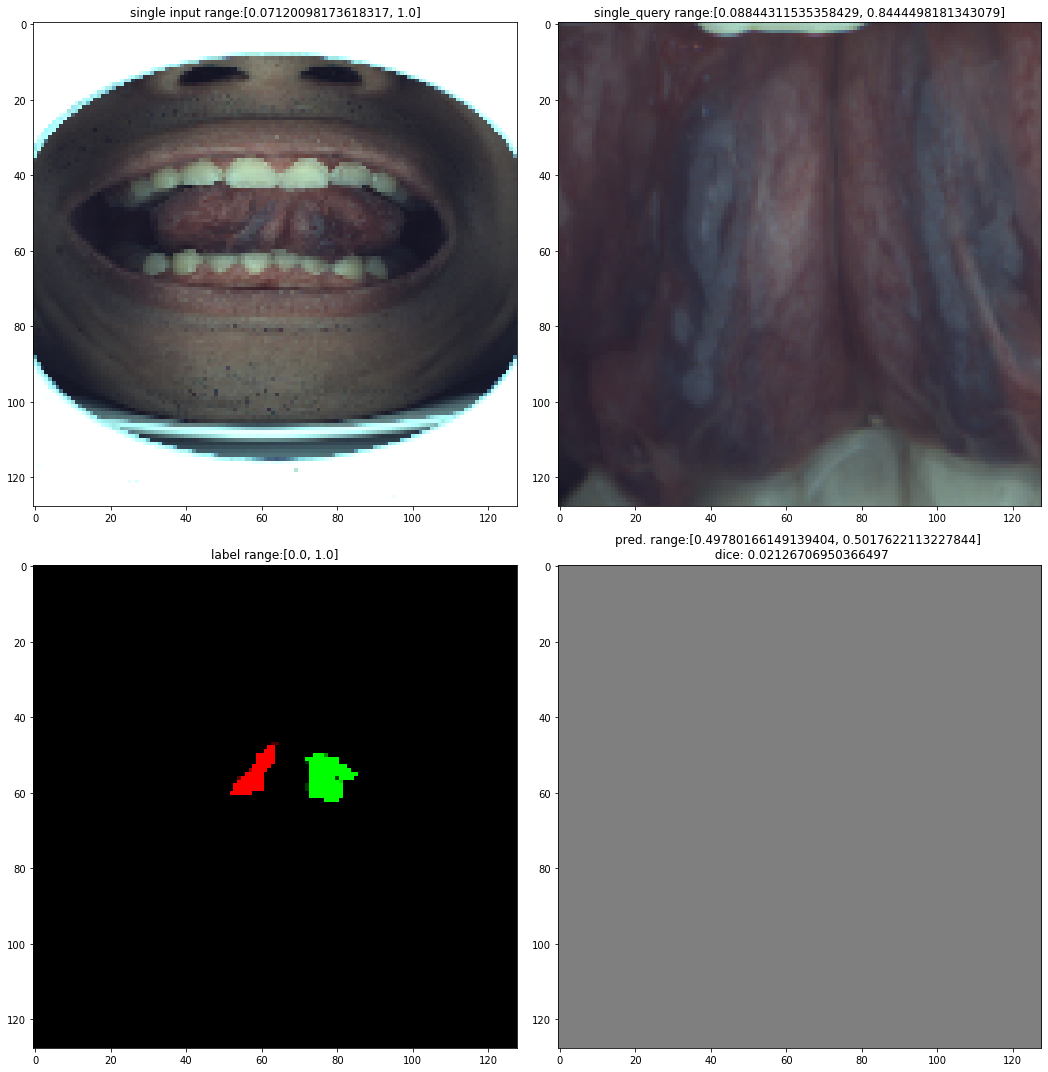

In [12]:
for final_element in final_train_dataset.take(1):
    tr_input =  final_element[0][0]
    tr_label =  final_element[0][1]
    tr_query =  final_element[1]
    print("tr_input.shape:", tr_input.shape)
    check_predict_images(One_shot_MobileNetV2UNet, [tr_input, tr_query], tr_label, 1, 1, save=False, Train_or_not=True, Epoch_val =False)

In [13]:
def write_single_total_loss_tb(writer, avg_losses, name, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing "+name +" logs to tensorboard...")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar(name, avg_losses.result(), step=epoch)
        
def write_single_scalar_tb(writer, avg_losses, name, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing "+ name +" logs to tensorboard...s")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar(name, avg_losses, step=epoch)
        
def train_display_save_at(model, batch_inputs, batch_labels,   step, epoch, pred, freq_step =200, save=True, Train_or_not=True):
    if step % freq_step ==0:
        print("train image checking----------------------------------------------------------------------------------->")
        check_predict_images(model, batch_inputs, batch_labels,  step, epoch, pred, save=save, Train_or_not=Train_or_not, Epoch_val =False)
        
def test_at_each_epoch(val_dataset, model, step, epoch, temp_dice, global_count_test, save=True, training=False):
    # initialize 
    epoch_val_flag = True
    # initialize for evaluating average metric
    test_total_loss_mean = tf.keras.metrics.Mean()
    test_total_dice_mean = tf.keras.metrics.Mean()
    test_total_ed_loss_mean = tf.keras.metrics.Mean()
    manual_avg_dice = []
    count = 0
    for te_final_element in val_dataset:
        te_input =  te_final_element[0][0]
        te_label =  te_final_element[0][1]
        te_query =  te_final_element[1]
        
        # one train step loss calculation and optimization  model2, inputs, cls_target, training
        te_total_loss, te_pred, te_dice, te_ed_loss = new_test_step(model, [te_input, te_query], te_label, training=False)
        test_total_loss_mean(te_total_loss)
        test_total_dice_mean(te_dice)
        test_total_ed_loss_mean(te_ed_loss)
#         test_loss_catches.append(te_total_loss)

        count+=1
        print('[Test]Epoch: {} batch:{} \n  total_loss set loss: {}, avg dice： {}, avg ed_loss: {}'.
              format(epoch, count, test_total_loss_mean.result(), test_total_dice_mean.result(), test_total_ed_loss_mean.result()))
        
        if global_count_test %25 ==0:
            display.clear_output(wait=True)
        
        

        current_batch_avg_dice = test_predict_all_images(model, [te_input, te_query], te_label,  epoch, int(global_count_test)%1) 
#         check_predict_images(model, [te_input, te_query], te_label, step, epoch, pred=te_pred, save=save, Train_or_not=training, Epoch_val=epoch_val_flag)                                               
#         display.clear_output(wait=True)
        print("global_count_test:", global_count_test)
        write_single_scalar_tb(val_summary_writer,  current_batch_avg_dice, "test_avg_batch_dice", int(global_count_test)) 
        
        global_count_test.assign_add(1)
        
        manual_avg_dice.append(current_batch_avg_dice)
    epoch_val_flag = False # one epoch finish so set flag back
    
    
#     # write logs to tensorboard:    avg_losses = [total_loss, seg_loss, cls_loss]
#     # write test losses to the tensorboard
    print("writing test logs to tensorboard...") 
    write_single_total_loss_tb(val_summary_writer, test_total_loss_mean, "total_loss_per_epoch", epoch)
    write_single_total_loss_tb(val_summary_writer, test_total_dice_mean, "Avg_dice_per_epoch", epoch)
    write_single_total_loss_tb(val_summary_writer, test_total_ed_loss_mean, "Avg_ed_loss_per_epoch", epoch)
    write_single_scalar_tb(val_summary_writer,  sum(manual_avg_dice)/len(manual_avg_dice), "Manul_test_avg_epoch_dice", epoch) 
    # check whether needs to save the model
    print("temp_dice:", temp_dice.numpy())
    if test_total_dice_mean.result() > temp_dice:
        save_path =  new_manager.save() # save the checkpoint and return the save path
        print("Saved checkpoint for epoch {}-  step {}: {}".format(epoch, step, save_path))
        temp_dice.assign(test_total_dice_mean.result())


# defin one epoch training for different dataset
def train_one_epoch(train_dataset, model, optimizer, step, epoch):
    #  initializations at each epoch 
    train_total_loss_mean = tf.keras.metrics.Mean()
    train_total_dice_mean = tf.keras.metrics.Mean()
    train_total_ed_loss_mean = tf.keras.metrics.Mean()
    
    for tr_final_element in train_dataset:
        tr_input =  tr_final_element[0][0]
        tr_label =  tr_final_element[0][1]
        tr_query =  tr_final_element[1]
 
        # one train step loss calculation and optimization
        tr_total_loss,tr_pred, tr_dice, tr_ed_loss = new_train_step(model, optimizer, [tr_input, tr_query], tr_label, training=True)
        train_total_loss_mean(tr_total_loss)
        train_total_dice_mean(tr_dice)
        train_total_ed_loss_mean(tr_ed_loss)
        
        if optimizer.iterations.numpy() % 10 == 0: 
            write_single_total_loss_tb(train_summary_writer, train_total_loss_mean, "train_total_loss_per_batch", optimizer.iterations.numpy())
            write_single_scalar_tb(train_summary_writer,  optimizer._decayed_lr(var_dtype=tf.float32), "Optimizer Lr", optimizer.iterations.numpy())
            write_single_scalar_tb(train_summary_writer,  train_total_dice_mean.result(), "tr_Dice", optimizer.iterations.numpy())
            write_single_scalar_tb(train_summary_writer,  train_total_ed_loss_mean.result(), "tr_ed_loss", optimizer.iterations.numpy())
        print('Epoch: {} batch:{} \n Train total_loss set loss: {}, train avg dice: {}, train avg ed_loss: {}'.
              format(epoch, int(step), train_total_loss_mean.result(), train_total_dice_mean.result(), train_total_ed_loss_mean.result()))
        
        #  model, Tr_dicom_paths, Tr_norm_input, Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,   step, epoch, freq_step =100, save=True, Train_or_not=True
        train_display_save_at(model, [tr_input, tr_query], tr_label,  int(step), epoch, tr_pred, freq_step =20, save=True, Train_or_not=True)

        if step % 25 ==0:
            display.clear_output(wait=True)


        step.assign_add(1)
        
    
     # write train epoch average loss to the tensorboard
    print("writing train logs to tensorboard...") 
    write_single_total_loss_tb(train_summary_writer, train_total_loss_mean, "total_loss_per_epoch", epoch)
    write_single_total_loss_tb(train_summary_writer, train_total_dice_mean, "Avg_dice_per_epoch", epoch)
    write_single_total_loss_tb(train_summary_writer, train_total_ed_loss_mean, "Avg_ed_loss_per_epoch", epoch)

In [14]:
# take_new_train_batches =  3035
def train_process(train_dataset, val_dataset, model, optimizer, step, start_epoch,global_test_step, global_dice_temp, total_epochs):
    # some initial parameters
    # test average_loss = for saving the test results
#     test_avg_tmp_dice =1
#     global_count_test = 1
    for epoch in range(int(start_epoch), total_epochs+1):
      
    
        # train one epoch， including loss calculation and optimization
        train_one_epoch(train_dataset, model, optimizer, step, epoch)
        
        # one training epoch ended start to evaluate the performance through entire test dataset
        test_at_each_epoch(val_dataset, model, int(step), epoch, temp_dice=global_dice_temp, global_count_test=global_test_step ,save=True, training = False)
      
      
        # when epoch fisnihed add epoch counter and reset the batch step 
        start_epoch.assign_add(1)     
        step.assign(1)
        
        
    # when training finihsed
    print("training finished") 

## train model

Epoch: 6 batch:51 
 Train total_loss set loss: 7.959285736083984, train avg dice: 0.0022964493837207556, train avg ed_loss: 6.960438251495361
Epoch: 6 batch:52 
 Train total_loss set loss: 7.959291458129883, train avg dice: 0.0022917750757187605, train avg ed_loss: 6.9604387283325195
Epoch: 6 batch:53 
 Train total_loss set loss: 7.9593071937561035, train avg dice: 0.0022807868663221598, train avg ed_loss: 6.9604387283325195
Epoch: 6 batch:54 
 Train total_loss set loss: 7.959286689758301, train avg dice: 0.002295008860528469, train avg ed_loss: 6.960439205169678
writing train_total_loss_per_batch logs to tensorboard...
writing Optimizer Lr logs to tensorboard...s
writing tr_Dice logs to tensorboard...s
writing tr_ed_loss logs to tensorboard...s
Epoch: 6 batch:55 
 Train total_loss set loss: 7.959294319152832, train avg dice: 0.002291802316904068, train avg ed_loss: 6.960439205169678
writing train logs to tensorboard...
writing total_loss_per_epoch logs to tensorboard...
writing Avg_di

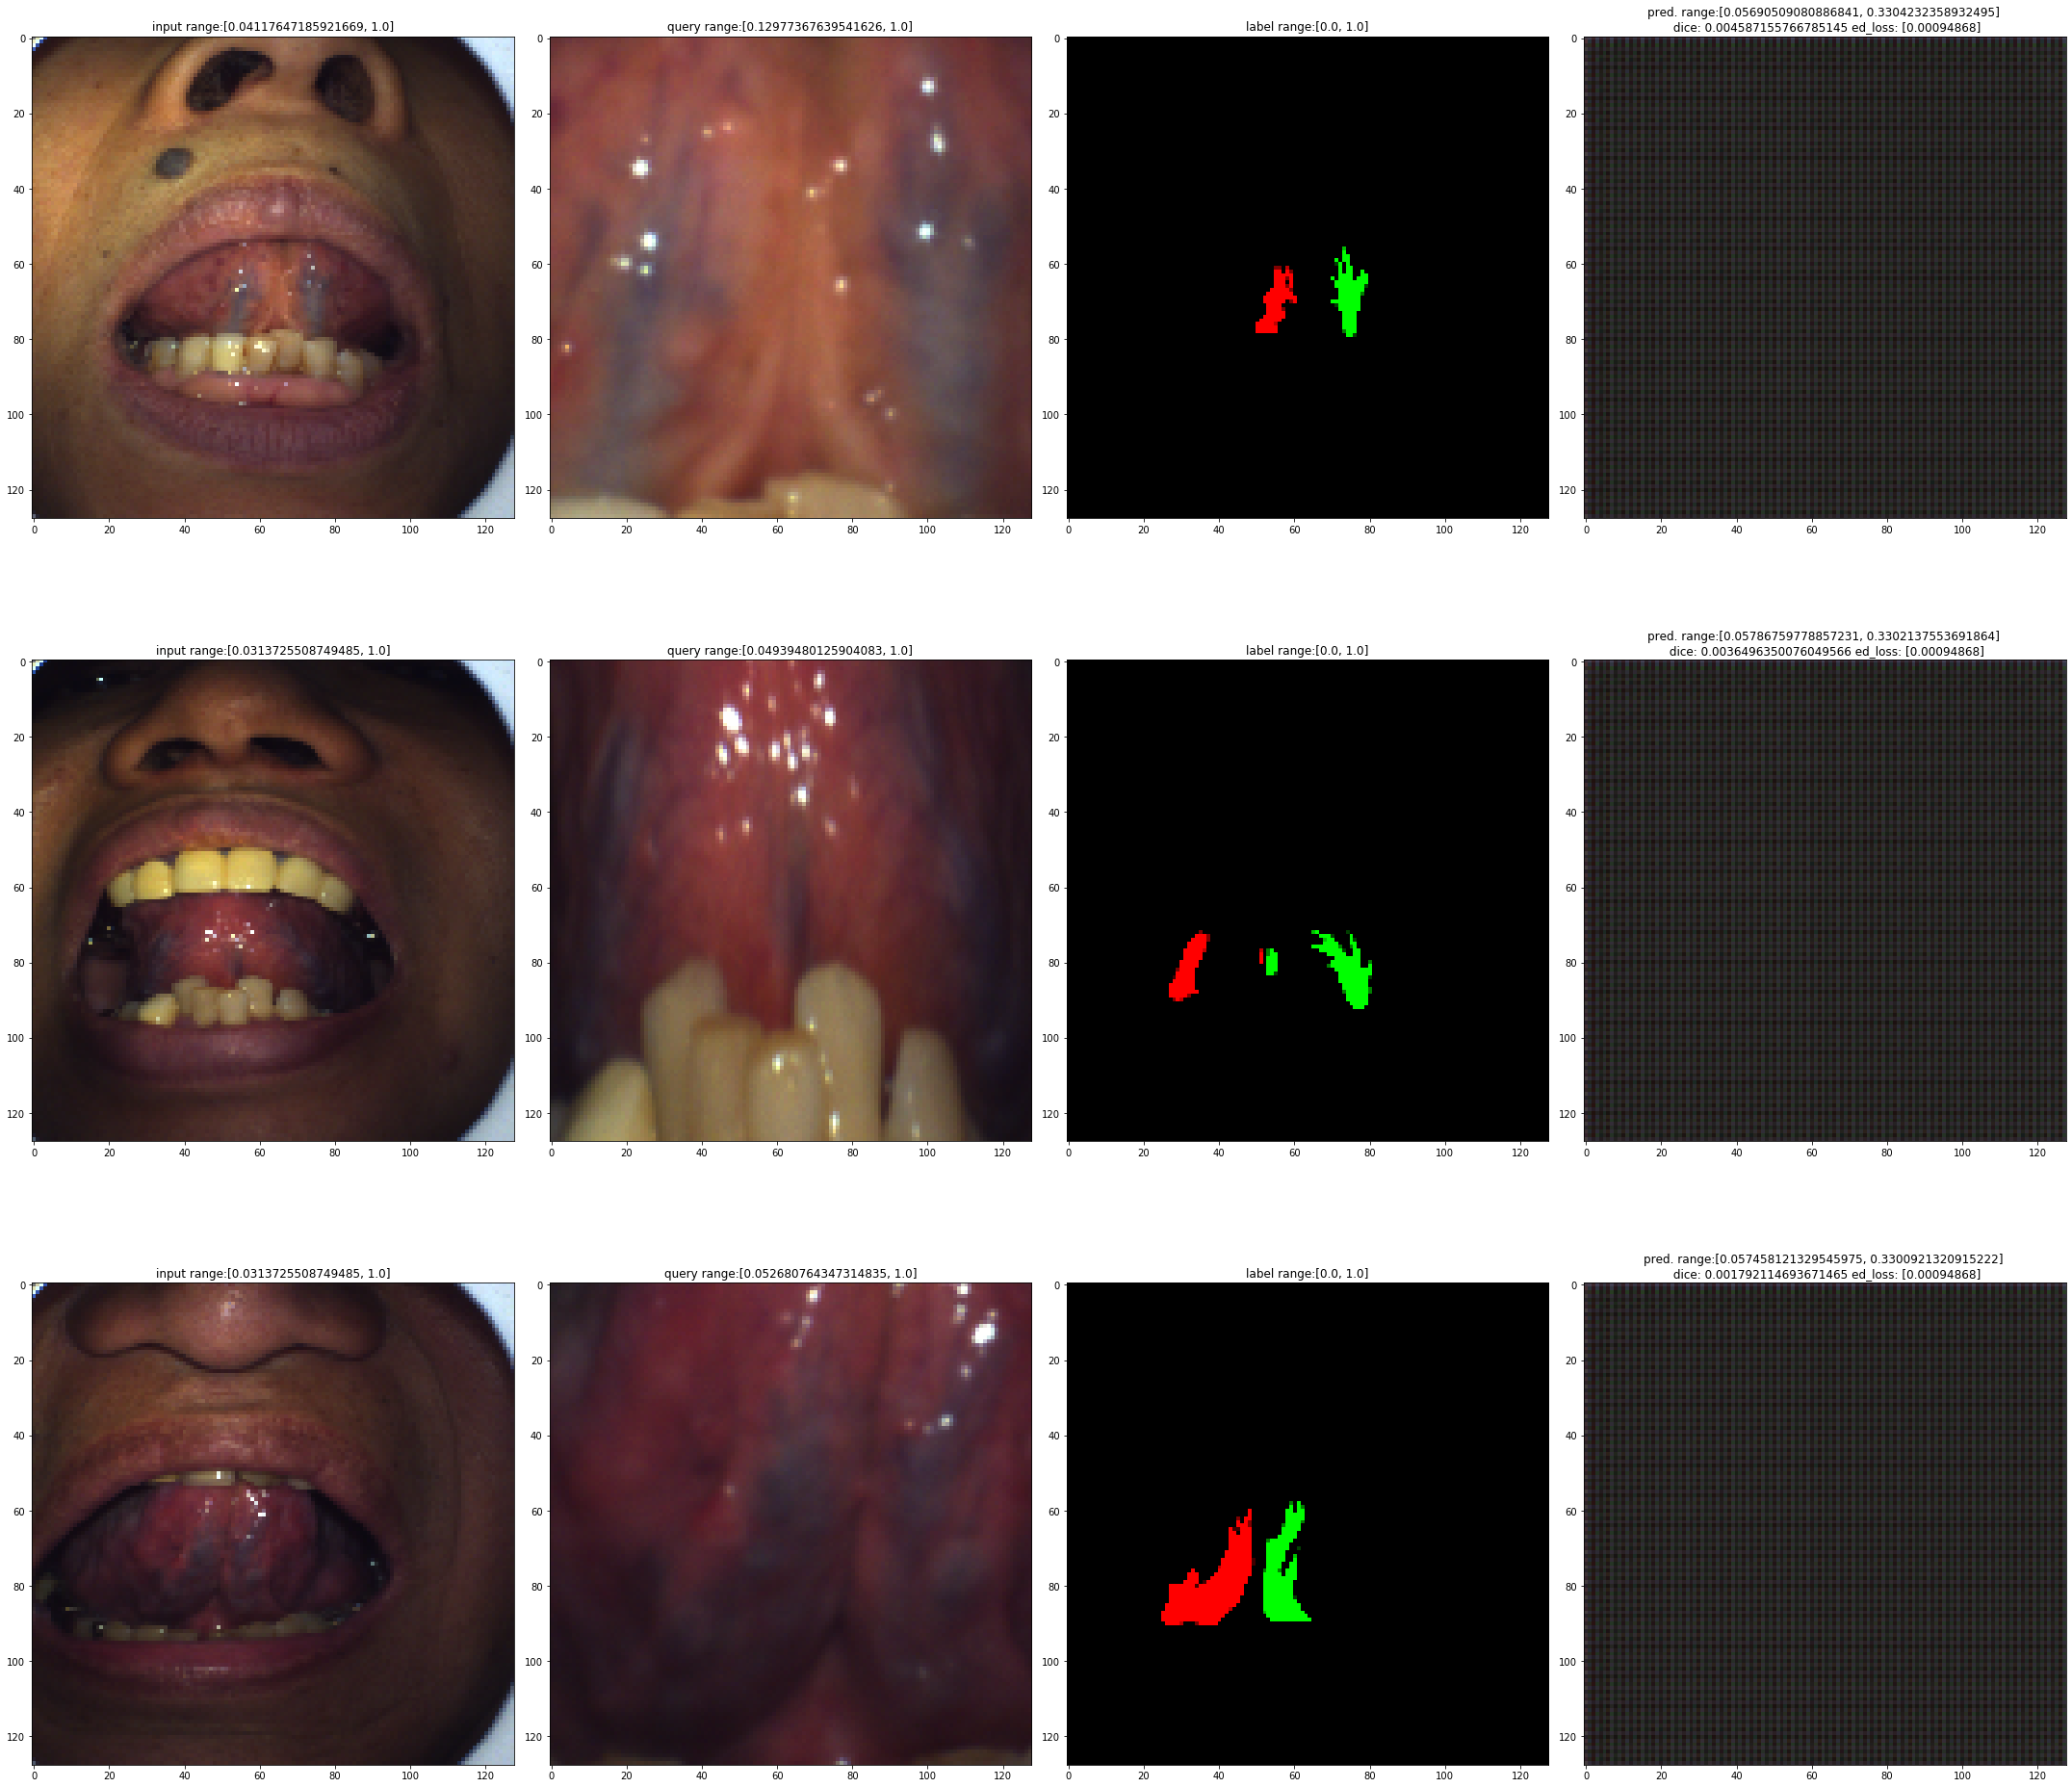

global_count_test: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=6>
writing test_avg_batch_dice logs to tensorboard...s
writing test logs to tensorboard...
writing total_loss_per_epoch logs to tensorboard...
writing Avg_dice_per_epoch logs to tensorboard...
writing Avg_ed_loss_per_epoch logs to tensorboard...
writing Manul_test_avg_epoch_dice logs to tensorboard...s
temp_dice: 0.0009541985
Epoch: 7 batch:1 
 Train total_loss set loss: 7.959650993347168, train avg dice: 0.0019960079807788134, train avg ed_loss: 6.960435390472412
Epoch: 7 batch:2 
 Train total_loss set loss: 7.959922790527344, train avg dice: 0.00184117432218045, train avg ed_loss: 6.960435390472412
Epoch: 7 batch:3 
 Train total_loss set loss: 7.95953369140625, train avg dice: 0.002093250397592783, train avg ed_loss: 6.960435390472412
Epoch: 7 batch:4 
 Train total_loss set loss: 7.95957088470459, train avg dice: 0.0020630345679819584, train avg ed_loss: 6.960435390472412
Epoch: 7 batch:5 
 Train total_loss set 

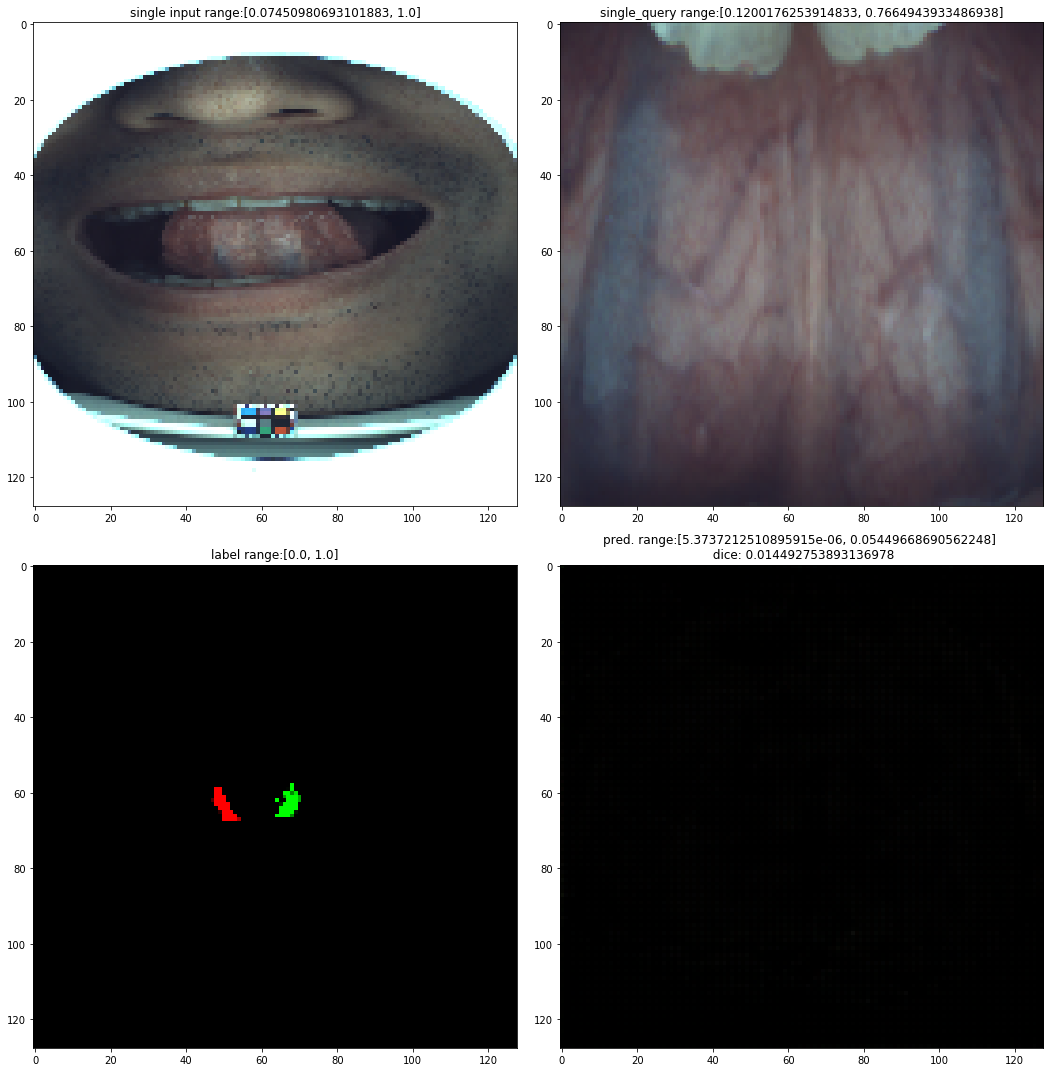

Epoch: 7 batch:21 
 Train total_loss set loss: 7.959296703338623, train avg dice: 0.002284713089466095, train avg ed_loss: 6.960434913635254
Epoch: 7 batch:22 
 Train total_loss set loss: 7.959266662597656, train avg dice: 0.0023033814504742622, train avg ed_loss: 6.960434436798096
Epoch: 7 batch:23 
 Train total_loss set loss: 7.959254264831543, train avg dice: 0.002309798961505294, train avg ed_loss: 6.960434436798096


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-dd35d62bbb20>", line 42, in <module>
    train_process(final_train_dataset, final_test_dataset, model, optimizer, step, ckpt_epoch, global_test_step, global_dice_temp, total_epochs=epochs)
  File "<ipython-input-14-7df9c805f938>", line 11, in train_process
    train_one_epoch(train_dataset, model, optimizer, step, epoch)
  File "<ipython-input-13-6a97a92ed9a4>", line 94, in train_one_epoch
    tr_total_loss,tr_pred, tr_dice, tr_ed_loss = new_train_step(model, optimizer, [tr_input, tr_query], tr_label, training=True)
  File "<ipython-input-10-323047c8e24a>", line 68, in new_train_step
    seg_pred, ed_skip_pred= model(inputs, training=training)
  File "E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\tensorflow_core\python\keras\engine\b

KeyboardInterrupt: 

In [15]:
import time
if __name__ == "__main__":
    
    init_lr = 5e-4
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=init_lr,
      decay_steps=10000,
      end_learning_rate=0.00005)
#     learning_rate_fn = 1e-3
    new_optimizer =  tf.keras.optimizers.Adam(learning_rate_fn)
    # build_new check point manager
    new_ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
    if not os.path.exists(new_ckpt_prefix):
        os.makedirs(new_ckpt_prefix)
    #  contents of states to be saved as attributes on the checkpoint object
    new_ckpt_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                      epoch=  tf.Variable(1),
                                      global_test_step =  tf.Variable(1),
                                      global_dice_temp =  tf.Variable(0.0),
                                        optimizer=new_optimizer,
                                         model =  One_shot_MobileNetV2UNet
                                     )
    # define checkpoint manager
    new_manager =  tf.train.CheckpointManager(new_ckpt_ob, new_ckpt_prefix, max_to_keep=1)

    # check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
    if new_manager.latest_checkpoint:
        print("Restored from {}".format(new_manager.latest_checkpoint))
        new_ckpt_ob.restore(new_manager.latest_checkpoint)
    else:
        print("Initializing from scratch.")

    # reset checkcpoint.step for each epoch
    step =  new_ckpt_ob.step
    ckpt_epoch =  new_ckpt_ob.epoch  
    optimizer = new_ckpt_ob.optimizer
    model = new_ckpt_ob.model
    epochs = 500
    global_test_step = new_ckpt_ob.global_test_step
    global_dice_temp = new_ckpt_ob.global_dice_temp
    # start train_process
    train_process(final_train_dataset, final_test_dataset, model, optimizer, step, ckpt_epoch, global_test_step, global_dice_temp, total_epochs=epochs)
